## 2022 EY Challenge - Sentinel-2 Pre-computed Median Mosaic

To assist with the challenge, our partners at NASA have created a pre-computed median mosaic from the [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data that you are free to access. This will allow you to use the Sentinel-2 dataset effectively without having to expend costly computational resources and time creating your own mosaics. The product contains only four bands, red, green, blue, and near-infrared, and was calculated over Australia, South Africa, and Costa Rica for the year of 2019. Here are some statistics about the product:

* Our regions in Australia, South Africa and Costa Rica cover 75-million square kilometers.
* There are nearly 80,000 Sentinel-2 scenes and 64-Terrabytes of data over these regions in one year.
* Our 2019 median mosaic is 434 GB of data which is 150x smaller than the baseline scene data.
* The mosaic product is stored in about 11,300 tiles covering 0.25-degree square latitude/longitude blocks.
* The mosaic took 20 hours to produce using 800 parallel virtual machines (VM). It would take one free Azure VM nearly 2 years to create the same product!

The full Sentinel-2 data is still available, so you may wish to create your own custom mosaics that cover additional bands captured by Sentinel-2. We have extensive documentation on how best to query the Sentinel-2 data and manage the computational load required to compute your own mosaics. 


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
import xrspatial.multispectral as ms

# Import function to obtain the precomputed mosaics
from SentinelMosaic import SentinelMosaic

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates. Our test region is near Richmond, NSW, Australia. The first line defines the lower-left corner of the bounding box and the second line defines the upper-right corner of the bounding box. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates.

In [2]:
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

In [3]:
# Initialise mosaic downloader. Specify download path
mosaic_downloader = SentinelMosaic(download_path='./data')

In [4]:
# Use the get_mosaic function to retrieve the relevant tiles for a given bounding box. 
# This function will download the relevant tiles to the download_path if it hasn't already, then it will read in the files and crop it to the bbox specified. 
# Some scenes may be corrupted or unavailable, making the function return None

median = mosaic_downloader.get_mosaic(bbox)

4 scenes intersect
Loading scene from: 	./data/EastAustralia/S33_50_E150_75
Loading scene from: 	./data/EastAustralia/S33_75_E150_75
Loading scene from: 	./data/EastAustralia/S33_50_E150_50
Loading scene from: 	./data/EastAustralia/S33_75_E150_50


In [5]:
print(median.sel(band="red"))

<xarray.DataArray 'stack-30bf821943ff2b4c2c7df3875b4fd9bb' (y: 2100, x: 2100)>
dask.array<getitem, shape=(2100, 2100), dtype=float32, chunksize=(1900, 1300), chunktype=numpy.ndarray>
Coordinates:
    band         <U5 'red'
  * x            (x) float64 150.6 150.6 150.6 150.6 ... 150.8 150.8 150.8 150.8
  * y            (y) float64 -33.48 -33.48 -33.48 ... -33.69 -33.69 -33.69
    spatial_ref  int64 0
    variable     <U9 'band_data'


To visualize the data, we'll use xarray-spatial's `true_color` and `ndvi` functions to display the results. The RGB image is what we would see with our eye if looking from space at the land. 

In [6]:
image = ms.true_color(median.sel(band="red"), median.sel(band="green"), median.sel(band="blue"))

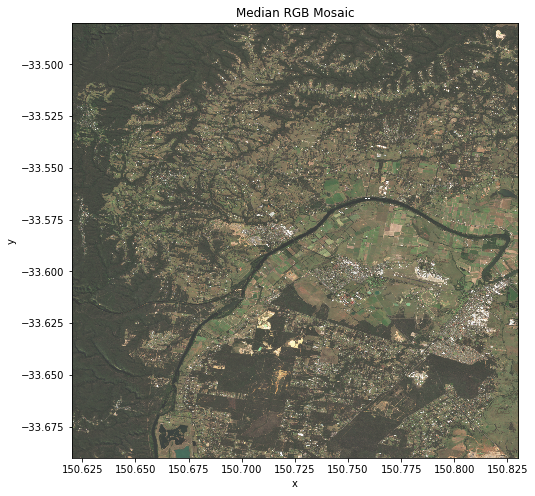

In [7]:
image.plot.imshow(figsize=(8,8))
plt.title("Median RGB Mosaic")
# plt.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [8]:
ndvi_median = ms.ndvi(median.sel(band="nir"), median.sel(band="red"))

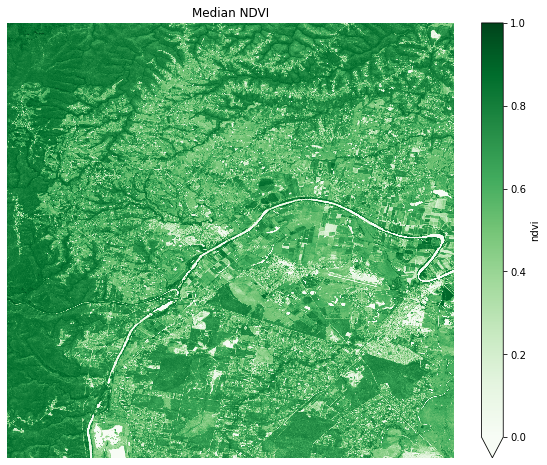

In [9]:
ndvi_median.plot.imshow(cmap="Greens", vmin=0.0, vmax=1.0, figsize=(10,8))
plt.title("Median NDVI")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file

In [10]:
filename = "S2_mosaic_sample2.tiff"

In [11]:
# This will report the pixel dimensions of our mosaic file. Recall that pixel resolution will impact the dimensions.
median.sel(band="red").shape

(2100, 2100)

In [12]:
# Set the dimensions of file in pixels
height = median.sel(band="red").shape[0]
width = median.sel(band="red").shape[1]

In [13]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(min_lon,min_lat,max_lon,max_lat,width,height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True);

In [14]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=4,compress='lzw',dtype='float64') as dst:
    dst.write(median.sel(band="red"),1)
    dst.write(median.sel(band="green"),2)
    dst.write(median.sel(band="blue"),3) 
    dst.write(median.sel(band="nir"),4)
    dst.close()

In [15]:
# Show the location and size of the new output file
!ls *.tiff -lah

-rw-rw-r-- 1 frog frog 41M May 18 02:45 S2_mosaic_sample2.tiff


### How will the participants use this data?
The mosaic data contains the Lat-Lon coordinates of each pixel and the median band values (Red, Green, Blue, NIR) for each pixel. These band values can be easily used to calculate indices such as NDVI (vegetation) or NDWI (water). Since the frog species training data also uses Lat-Lon position, it is possible to find the closest Sentinel-2 mosaic pixel using code similar to what is demonstrated below. This process can be repeated for each frog species sample in the training data. In the end, the Sentinel-2 spectral data from this mosaic can be used for modeling species distribution.

Here are some other things to consider as you apply this data to your models. The closest pixel to any frog location may not be the 'best' representation of the surrounding vegetation or land conditions. For example, the frog location may have been acquired near a building or road that could skew the spectral data. So, participants may want to use methods that consider spectral data in the 'proximity' to any frog location as this might better reflect the surrounding vegetation or land conditions.

Another possible issue is exceeding cloud computing memory limits. This may happen if you load large amounts of mosaic data prior to searching for corresponding frog locations. So, participants may want to calculate their desired spectral information for each frog location and only store that final result for later use in their model.


In [16]:
# This is an example for a specific Lon-Lat location randomly selected within our sample region.
values = median.sel(x=-83.00, y=8.00, method="nearest").values    
print("These are the band values (R,G,B,NIR) for the closest pixel: ", values)

These are the band values (R,G,B,NIR) for the closest pixel:  [  57.  141. 1404.   61.]
